# Multi Agent Suprvisor With RAG

Supervisor is a multi-agent architecture where specialized agents are coordinated by a central supervisor agent. The supervisor agent controls all communication flow and task delegation, making decisions about which agent to invoke based on the current context and task requirements.

In this tutorial, you will build a supervisor system with two agents — a research and a math expert. By the end of the tutorial you will:

1. Build specialized research and math agents
2. Build a supervisor for orchestrating them with the prebuilt langgraph-supervisor
3. Build a supervisor 
4. Implement advanced task delegation


In [1]:
import os
from typing import Annotated, Literal
from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain.agents import Tool
from langchain_community.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
from langgraph.graph import START, StateGraph, MessagesState, END
from langgraph.types import Command
from dotenv import load_dotenv


In [2]:
load_dotenv()

True

In [3]:
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
embeddings = OpenAIEmbeddings()
llm = init_chat_model("openai:gpt-4o-mini")

## Create Tools

In [5]:
web_search = TavilySearch(max_results=3)
web_search

TavilySearch(max_results=3, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))

In [6]:
def make_retriever_tool_from_text(file, name, description, chunk_size=500, chunk_overlap=50):
    documents = TextLoader(file_path=file, encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap).split_documents(documents=documents)
    
    vector_store = FAISS.from_documents(
        documents=chunks, 
        embedding=embeddings
    )

    retriever = vector_store.as_retriever()

    def tool_function(query:str) -> str:
        print(f"📚 Using Tool: {name}")
        results = retriever.invoke(input=query)
        return "\n\n".join(result.page_content for result in results)
    
    return Tool(name=name, description=description, func=tool_function)


internal_document_tool = make_retriever_tool_from_text(
    file="internal_docs.txt",
    name="InternalResearchNotes", 
    description="Search internal research notes for experimental results"
)

internal_document_tool

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_function at 0x000001C2F10377E0>)

## Create Custom Tools

In [7]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b

def subtract(a: float, b: float):
    """Subtract two numbers."""
    return a - b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b

## Create Agents

### Research Agent

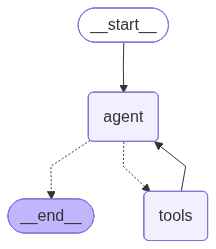

In [8]:
research_agent = create_react_agent(
    model=llm,
    tools=[web_search, internal_document_tool],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent"
)

research_agent

### Maths Agent

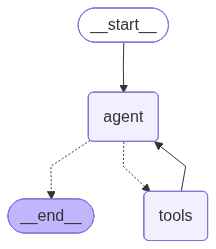

In [9]:
math_agent = create_react_agent(
    model=llm,
    tools=[add, subtract, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent"
)

math_agent

## Create Supervisor Agent

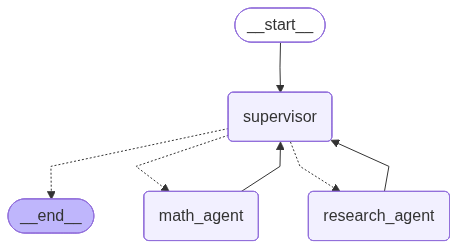

In [10]:
supervisor_agent = create_supervisor(
    model=llm,
    agents=[research_agent, math_agent],
    prompt=(
         "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."

    ),
    add_handoff_back_messages=True,
    output_mode="full_history"
).compile()

supervisor_agent

In [11]:
query = "list all the transformer variants in production deployments from the retriever and then tell me what is 5 plus 10"

response = supervisor_agent.invoke({"messages":query})

📚 Using Tool: InternalResearchNotes


In [12]:
response

{'messages': [HumanMessage(content='list all the transformer variants in production deployments from the retriever and then tell me what is 5 plus 10', additional_kwargs={}, response_metadata={}, id='02e25d04-46b4-4840-bbab-88037ef196d3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_79Bno6XGZuHAQFLHLdEeVZ4y', 'function': {'arguments': '{}', 'name': 'transfer_to_research_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 142, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CMDV8uJioH30gRdG3TNec9NkrTOyf', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--8e7d87d9-8

In [13]:
response["messages"][-1].content

'The transformer variants in production deployments are:\n\n1. **EfficientFormer**\n   - Optimized for mobile inference.\n   - Deployed in mobile and edge environments.\n   - Quantized using ONNX and optimized via TensorRT.\n   - Benchmark: 1.2ms inference time on A72 CPUs.\n\n2. **Reformer**\n   - Tested for memory efficiency on embedded devices.\n   - LSH attention achieved a 60% memory reduction.\n   - Investigated for training stability and gradient clipping strategies.\n\nAdditionally, various vision and speech transformers have been evaluated for specific tasks, and improvements have been made with techniques like FlashAttention and Rotary Positional Encoding.\n\nRegarding the math question, 5 plus 10 equals **15**.'